In [1]:
#Customizando el color del texto en el print()
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.colors as mcolors
import seaborn as sns
sns.set_theme(style="whitegrid")

In [3]:
data=pd.read_csv("Barcelona_Fotocasa_HousingPrices.csv")
data.head()

,Unnamed: 0,price,rooms,bathroom,lift,terrace,square_meters,real_state,neighborhood,square_meters_price
0,0,750,3,1,True,False,60,flat,Horta- Guinardo,12.500000
1,1,770,2,1,True,False,59,flat,Sant Andreu,13.050847
2,2,1300,1,1,True,True,30,flat,Gràcia,43.333333
3,3,2800,1,1,True,True,70,flat,Ciutat Vella,40.000000
4,4,720,2,1,True,False,44,flat,Sant Andreu,16.363636


In [4]:
#Eliminando la primera columna
data.drop("Unnamed: 0",inplace=True,axis=1)

In [5]:
f,c =data.shape
print(color.PURPLE +color.BOLD + color.UNDERLINE +'viviendas:'+ color.END,f'{f} filas y {c} columnas')

viviendas: 8188 filas y 9 columnas


In [6]:
#Viendo los tipos de variable
for i,attr in enumerate(data.columns.tolist(),start=1):
    dtype= data[attr].dtype
    if dtype == "object":
        print(color.YELLOW+color.BOLD +f'{i:>2}.{attr:<20} {dtype}'+color.END)
    elif dtype == "int64":
        print(color.RED+color.BOLD +f'{i:>2}.{attr:<20} {dtype}'+color.END)
    elif dtype == "bool":
        print(color.DARKCYAN+color.BOLD +f'{i:>2}.{attr:<20} {dtype}'+color.END)
    else:
        print(color.BLUE+color.BOLD +f'{i:>2}.{attr:<20} {dtype}'+color.END)     

 1.price                int64
 2.rooms                int64
 3.bathroom             int64
 4.lift                 bool
 5.terrace              bool
 6.square_meters        int64
 7.real_state           object
 8.neighborhood         object
 9.square_meters_price  float64


In [7]:
#Cambiando de boleana a object
data["lift"]=data["lift"].astype(object)
data["terrace"]=data["terrace"].astype(object)

In [8]:
#Checkeando los valores nulos
data.isnull().sum()

price                    0
rooms                    0
bathroom                 0
lift                     0
terrace                  0
square_meters            0
real_state             268
neighborhood             0
square_meters_price      0
dtype: int64

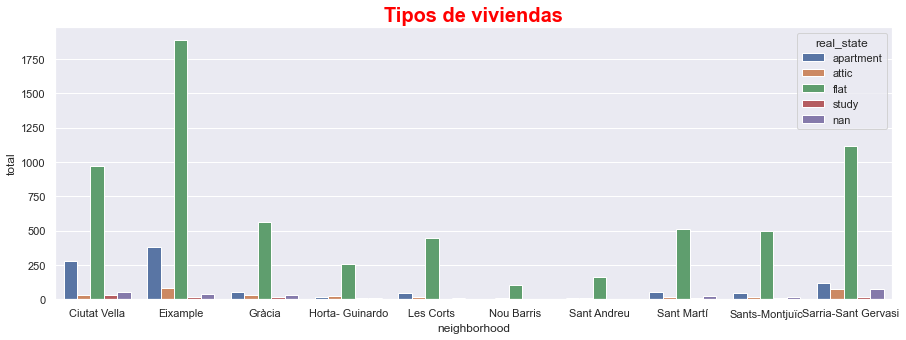

In [10]:
# Tipos de viviendas por distrito
columnas=["neighborhood","real_state","price"]
viviendas=data[columnas].groupby(["neighborhood","real_state"],dropna=False,as_index=False).count()
viviendas.rename(columns={"price":"total"},inplace=True)
viviendas.fillna("nan",inplace=True)
sns.barplot(x="neighborhood",hue="real_state",y="total",data=viviendas)
sns.set_theme(rc={'figure.figsize':(15,5)})
plt.title("Tipos de viviendas",color="red",fontweight="bold",size=20)
plt.show()

Por tanto, a fines prácticos se reemplazará los valores nulos en el tipo de vivienda a `flat`

In [11]:
data.fillna("flat",inplace=True)

### Análisis de correlación
En el primer análisis se omite `price` 

[]

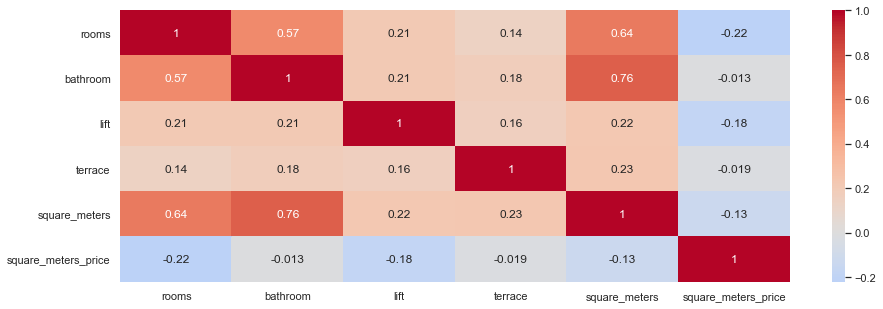

In [12]:
correlacion=data.drop("price",axis=1).corr()
sns.heatmap(correlacion, annot=True, cmap="coolwarm", center=0)
plt.plot()

Programa auxiliar:

In [13]:
#Tranformar variables categóricas a numéricas 
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
def analisis(attr):
    #2 graficoss
    variables_counted=data[attr].value_counts(dropna=False,ascending=True).sort_index()
    variables_counted_df =pd.DataFrame({"x":variables_counted.index,"y":variables_counted.values})
    dtype= data[attr].dtype
    plt.figure(figsize=(18,10))
    ax1=plt.subplot(211)
    if (dtype== "float64") or (dtype=="int64" and variables_counted.size>30):
        sns.histplot(data=data[attr],bins=100)
        ax1.set(xlabel="",ylabel="")
        ax2=plt.subplot(212,sharex=ax1)
        sns.scatterplot(data=data,x=attr,y="price")
    elif dtype=="object":
        sns.barplot(data=variables_counted_df,x="y",y="x")
        ax1.set(xlabel="",ylabel="")
        ax2=plt.subplot(212)
        sns.boxplot(data=data,y='price',x=attr)
    else:
        sns.barplot(data=variables_counted_df,x="x",y="y")
        ax1.set(xlabel="",ylabel="")
        ax2=plt.subplot(212,sharex=ax1)
        sns.boxplot(data=data,y='price',x=attr)
    plt.suptitle(attr,fontsize=18,fontweight="bold",color="red")
    plt.show()
    #Coeficiente de correlación 
    df= data[[attr,'price']]
    if dtype == 'object':
        df[attr]=le.fit_transform(df[attr])
    corr=df.corr().iloc[0,1]
    print(color.PURPLE+ 'CORRELACIÓN:'+ color.END + f' {attr} y price: {round(corr,2)}')
    print("-"*120)
    

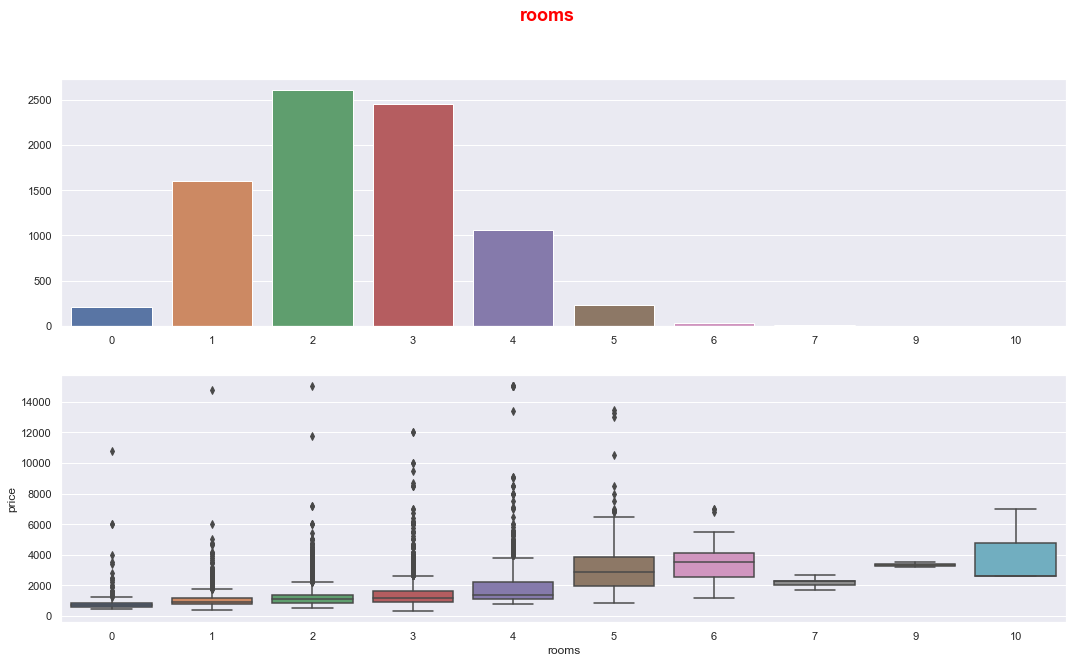

CORRELACIÓN: rooms y price: 0.35
------------------------------------------------------------------------------------------------------------------------


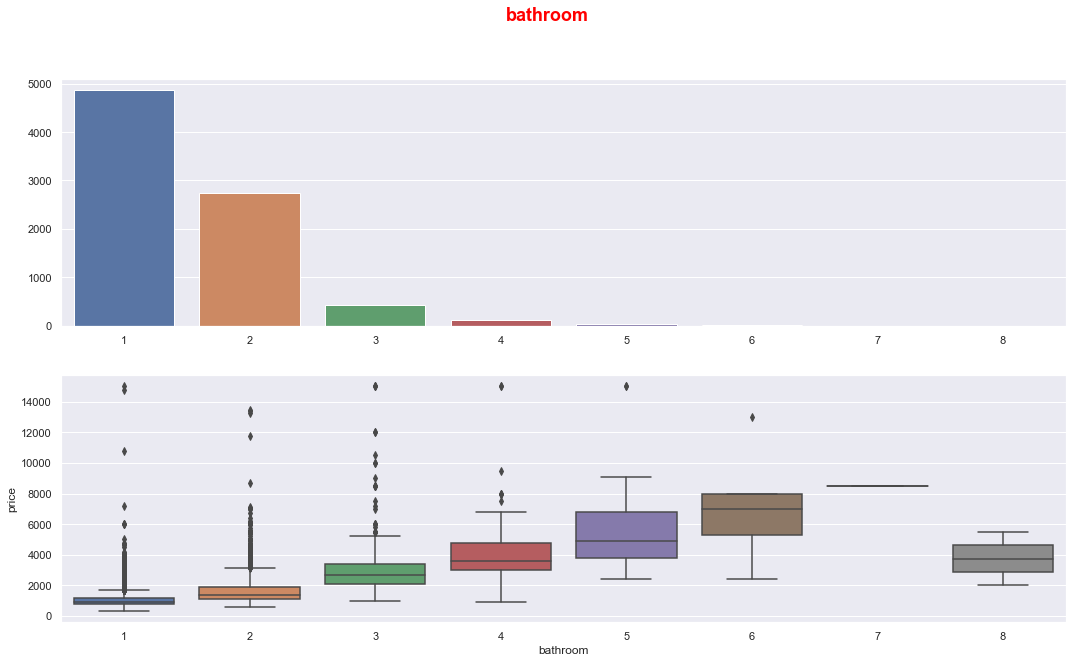

CORRELACIÓN: bathroom y price: 0.58
------------------------------------------------------------------------------------------------------------------------


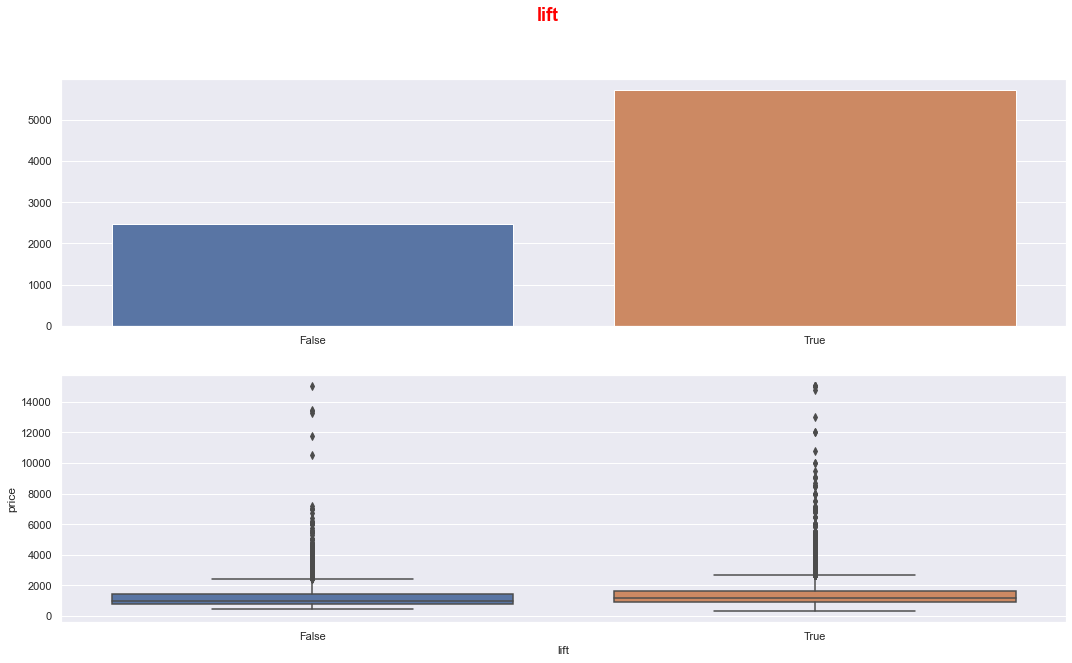

CORRELACIÓN: lift y price: 0.06
------------------------------------------------------------------------------------------------------------------------


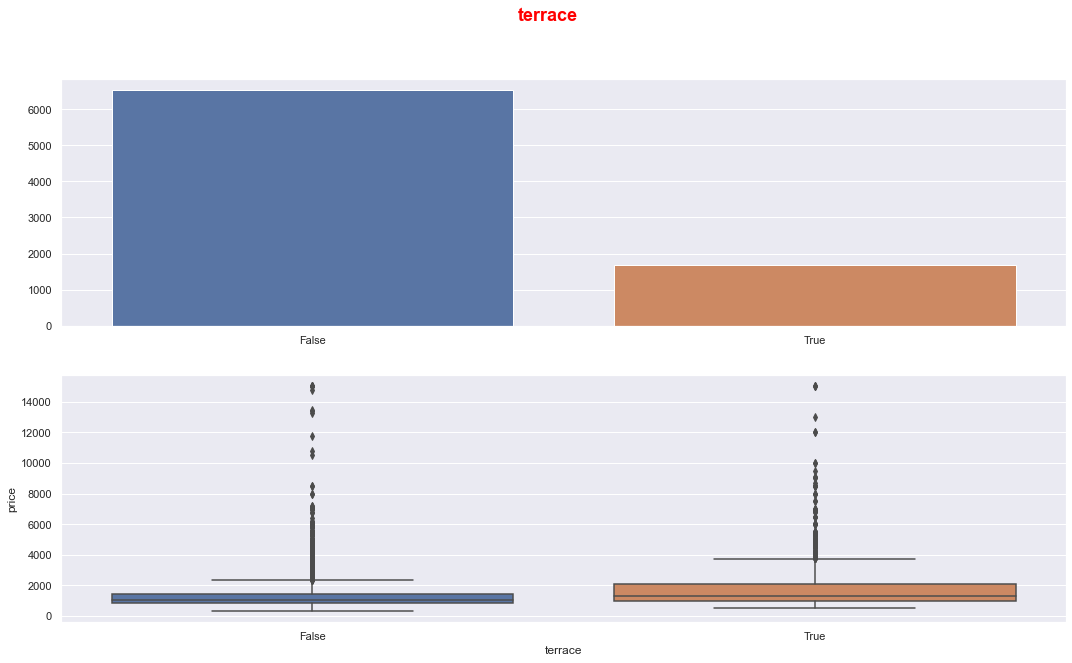

CORRELACIÓN: terrace y price: 0.17
------------------------------------------------------------------------------------------------------------------------


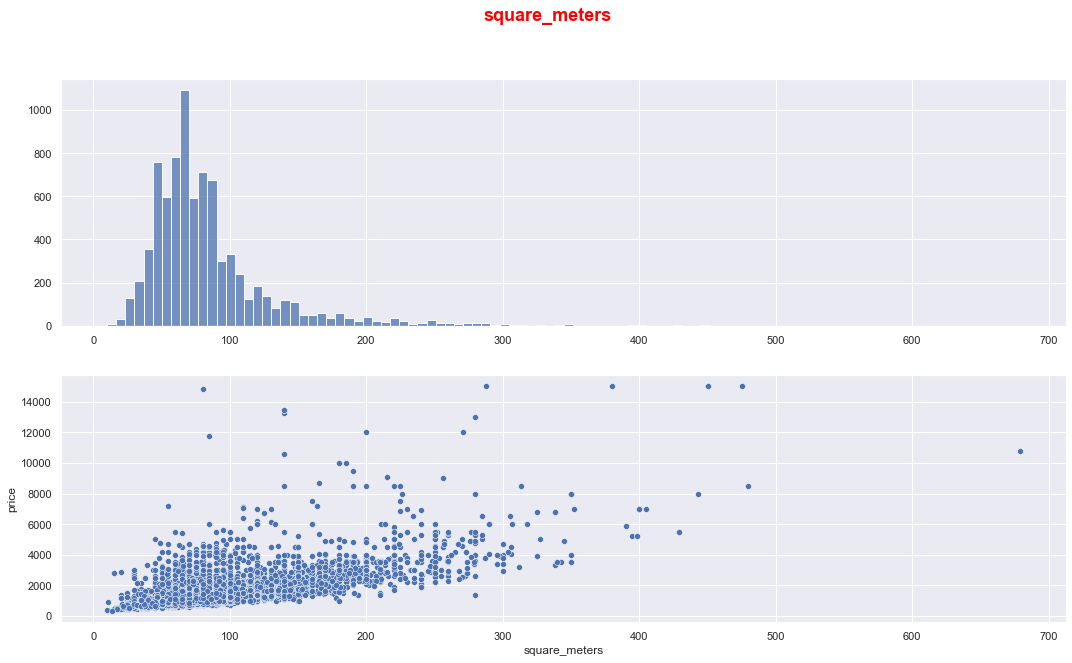

CORRELACIÓN: square_meters y price: 0.69
------------------------------------------------------------------------------------------------------------------------


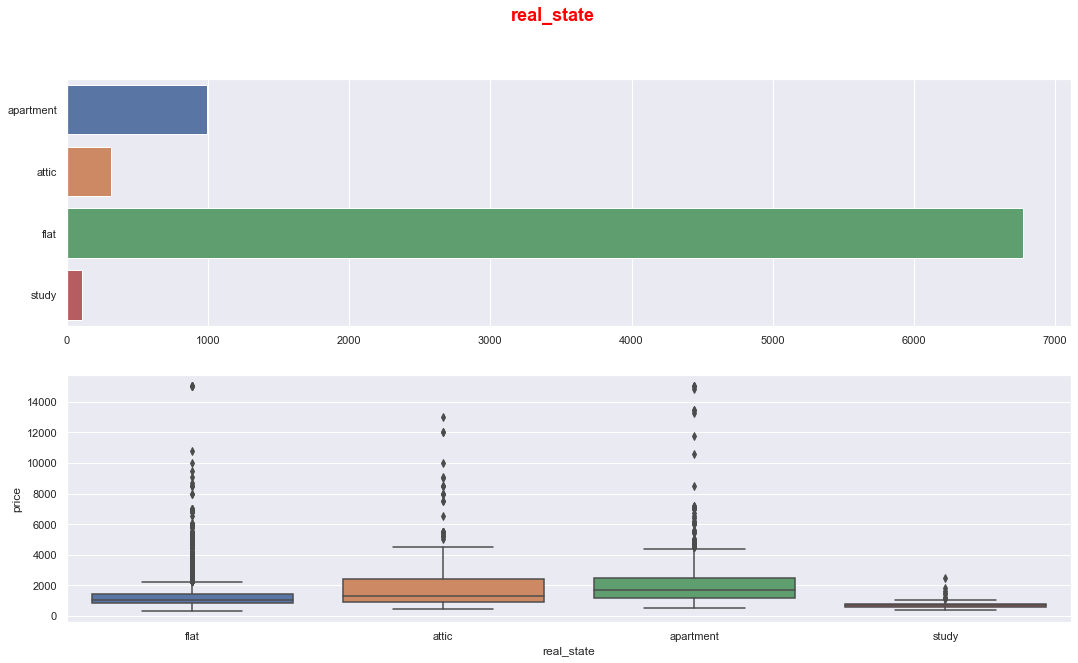

CORRELACIÓN: real_state y price: -0.25
------------------------------------------------------------------------------------------------------------------------


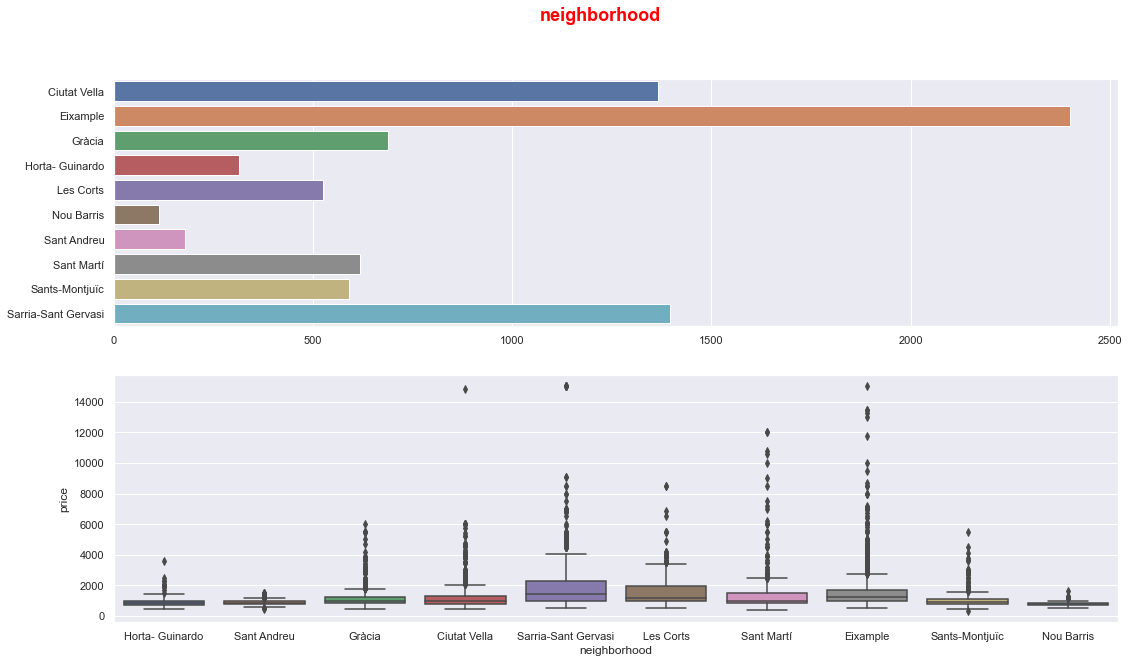

CORRELACIÓN: neighborhood y price: 0.09
------------------------------------------------------------------------------------------------------------------------


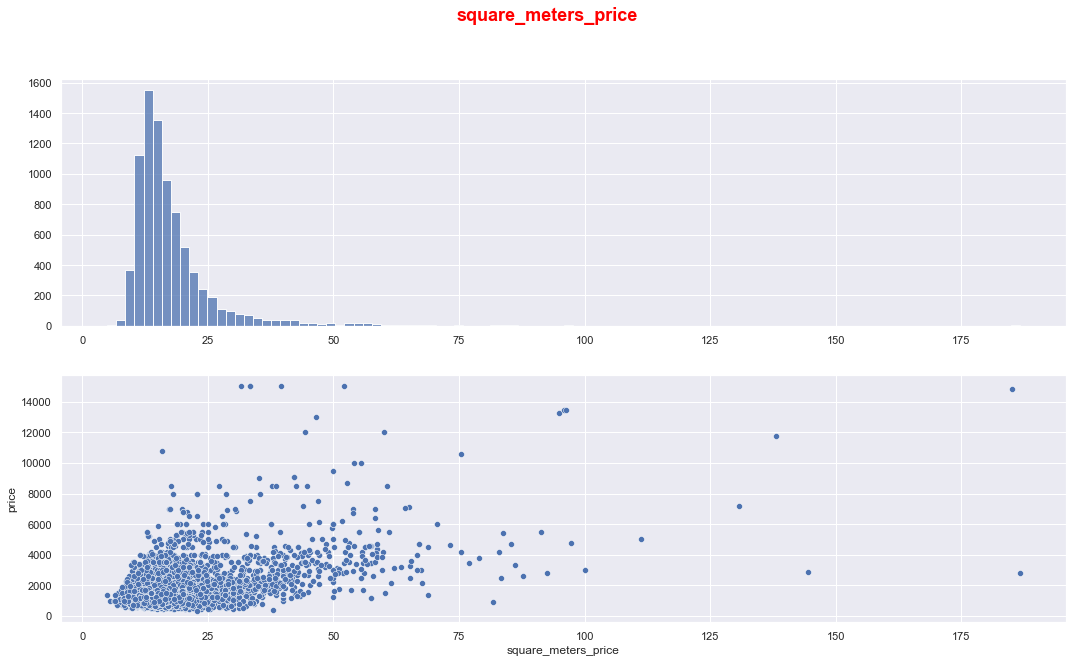

CORRELACIÓN: square_meters_price y price: 0.52
------------------------------------------------------------------------------------------------------------------------


In [14]:
for attr in data.columns:
    if attr !="price":
        analisis(attr)

### Transformación de variables de categóricas a numéricas

- `real_state`
- `neighborhood`
- `lift`
- `terrace` 

In [15]:
cols_tranformar=["real_state","neighborhood","lift","terrace"]
for col in cols_tranformar:
    data[col]=le.fit_transform(data[col])
#A archivo csv
data.to_csv("data_preprocessed.csv",index=False)